# HW 2: Machile Learning Pipeline 
#### James Jensen 



In [26]:
%reload_ext autoreload
%autoreload 2

In [27]:
import explore
import pipeline
import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from matplotlib import cm
import joypy

### Read/Load Data 
In the following cell, I call the load_data() function from pipeline.py, which takes the path of a csv file and returns a pandas dataframe.

In [3]:
filename = 'credit-data.csv'
df = pipeline.load_data(filename)

### Explore Data 
In the following cells, I make use of functions from explore.py to provide me with a better understanding of the underlying data before I conduct any analysis. I provide visualizations of the distributions of several variables, a heatmap demonstrating correlations among the variables, key outliers, data summaries, and insight into missing data -- if it appears to be missing at random, or if there is a pattern as to why it's missing. 

My columns are interested are labeled: COL_NAMES = ['NumberOfTimes90DaysLate', 'DebtRatio', 'age']

As the heatmap demonstrate, our target variable, SeriousDlqin2yrs is most strongly correlated with NumberofTime90DaysLate, NumberofTimes20-59DayPastDue, and NumberofTimes60-89DayPastDue. There seems to be a weaker but still positive correlation between the target variable and the NumberOfDependets. As for the remaining variables there appear to be strong correlations between age and the number of real estate loans and between number of real estate loans and number of open credit lines.

When looking for outliers, the summary statistics of the DebtRatio stand out the most -- DebtRatio has a mean of 331 and a median of .36, as well the 75th percentile equivalent to .86.

When looking into the deliquency rate per zipcode, one zipcode stood out: 60644. With over 2500 records from zipcode 60644 in the dataset, none of them had a value of 1 for deliquency. 

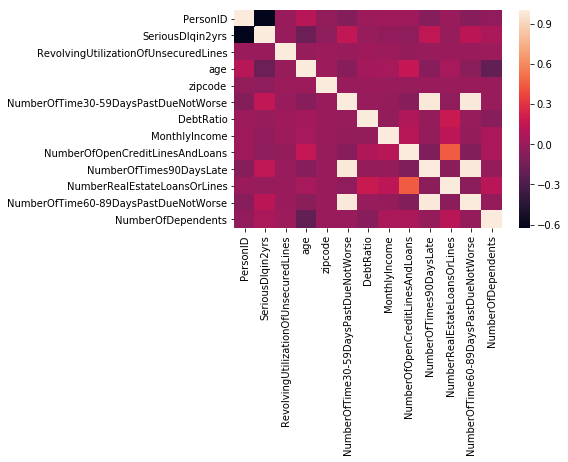

In [4]:
explore.make_heatmap(df)

In [5]:
COL_NAMES = ['NumberOfTimes90DaysLate', 'DebtRatio', 'age', 'MonthlyIncome']
explore.summarize(df, COL_NAMES)

count    41016.000000
mean         0.419592
std          5.190382
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTimes90DaysLate, dtype: float64
count     41016.000000
mean        331.458137
std        1296.109695
min           0.000000
25%           0.176375
50%           0.369736
75%           0.866471
max      106885.000000
Name: DebtRatio, dtype: float64
count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64
count    3.304200e+04
mean     6.578996e+03
std      1.344683e+04
min      0.000000e+00
25%      3.333000e+03
50%      5.250000e+03
75%      8.055750e+03
max      1.794060e+06
Name: MonthlyIncome, dtype: float64


#### Missing Records
The following matrix visualizes location of missing records by index. This enables us to determine if missing records occur randomnly or are bunched together. Variation in both Number of Independents and Monthly Income appear to be random. The bar chart displays which columns have missing records and the total number of records missing. MonthlyIncome is missing 7,974 and NumberOfDependents is missing 1,037. 

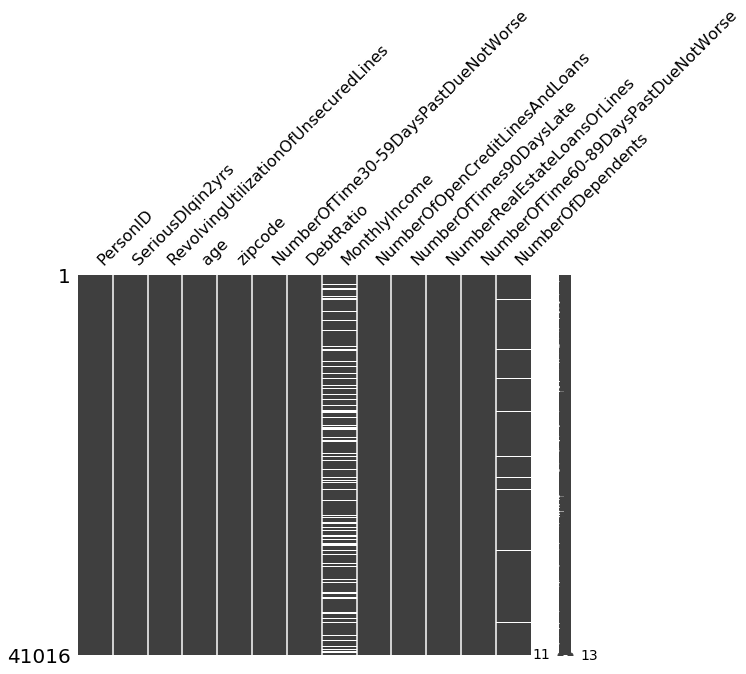

In [6]:
explore.missing_matrix(df)

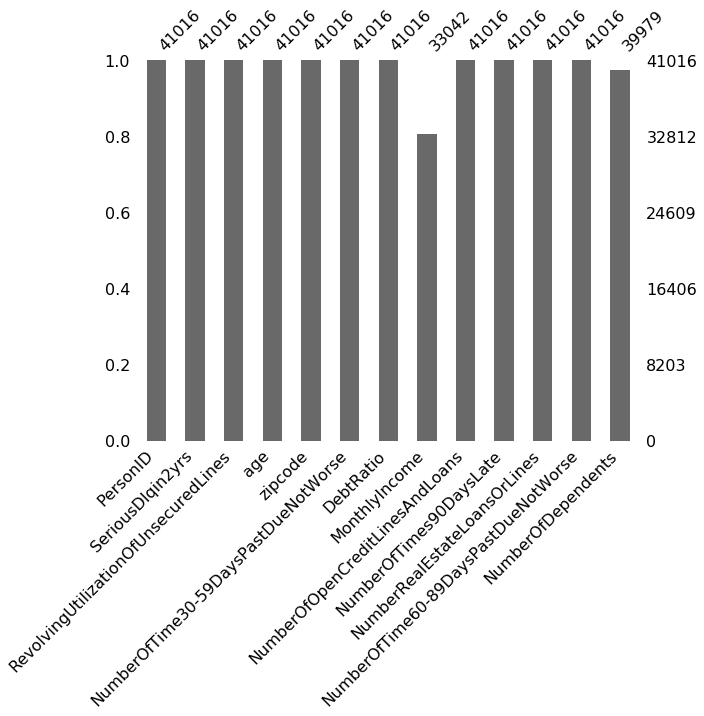

In [24]:
#Displays number of expected rows and number of actual for each column.
explore.missing_bar(df)

### Pre-Process Data 
At this stage, I call the fill_null() function in pipeline.py to fill missing values with the median value from the respective column.

In [7]:
pipeline.fill_null(df)

### Distributions

Using a variety of plot types -- density plots, box plots, and violin plots -- I explored the distributions of several variables as well as distribution of variables by zipcode in order to see if certain features are more likely to occur in a given area. 

The first density plot illustrates that MonthlyIncome is clearly not normally distributed -- there exist extreme outliers, values upwards of 10 standard deviations from the mean. Since the dispersion is so large, I created a new column -- NatLog_MonthlyIncome -- that is a log transformation of MonthlyIncome. The second graph is a cumulative density function combined with a histogram for NumberOfDependents. From this we can see that 90% of all individuals in our data claim to have 3 or fewer dependents. The third graph is a histogram of the age column, close to but not quite a normal distribution. The 4th graph is a boxplot of the natural log of monthly income grouped by zipcode. The median income is similar for each zipcode, however we can see large, positive outliers for certain zipcodes -- specifically 60601 -- as well as extreme outliers below the lower quartile -- 60625 and 60637. The following plot is a violin plot, which demonstrates the distribution of NumberOfOpenCreditLinesAndLoans per individual grouped by zipcode. Two things stand out: (1) the majority of open loans for each zipcode is less than 10; and (2) zipcode 60618 has the the largest positive outliers and has the smallest median value. The hexplot can visualize correlation between two different variables (NatLog_MonthlyIncome and NumberOfTimes30-59Days) as well as their respective distributions. 

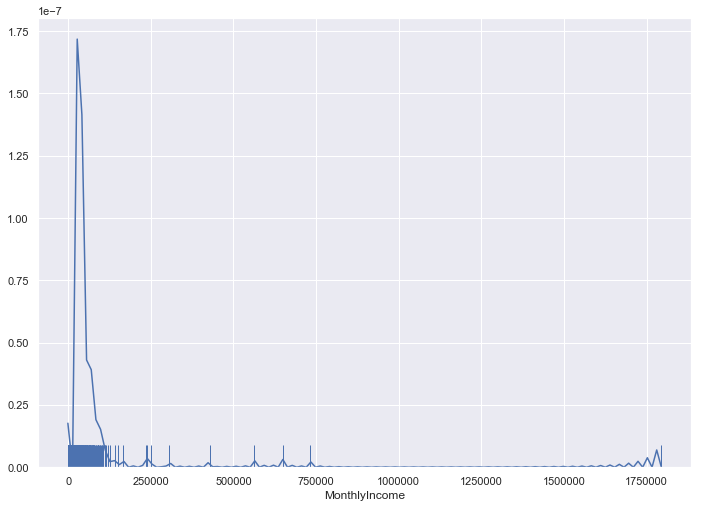

In [8]:
# explore.plot_distribution(df, x='MonthlyIncome')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['MonthlyIncome'], hist=False, rug=True)

In [9]:
df['NatLog_MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: np.log(x))

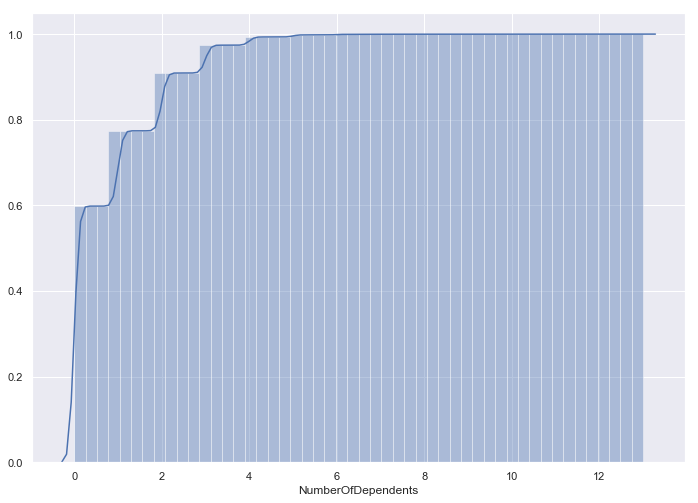

In [10]:
sns.distplot(df['NumberOfDependents'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

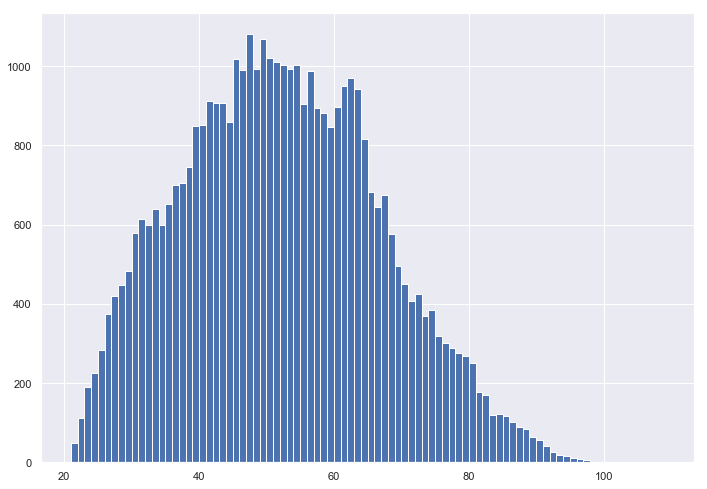

In [11]:
df['age'].max() - df['age'].min()
df['age'].hist(bins=88)

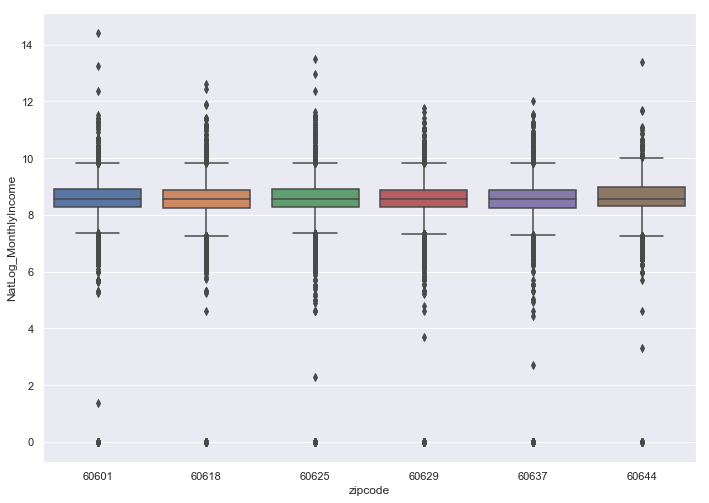

In [12]:
np.isinf(df).sum()
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
ax = sns.boxplot(data=df, x='zipcode',y='NatLog_MonthlyIncome')

In [13]:
LOC = 'zipcode'
TARGET = 'SeriousDlqin2yrs'
explore.target_loc_dist(df, TARGET, LOC)

zipcode
60601    0.170042
60618    0.177211
60625    0.169888
60629    0.167866
60637    0.180865
60644         NaN
dtype: float64

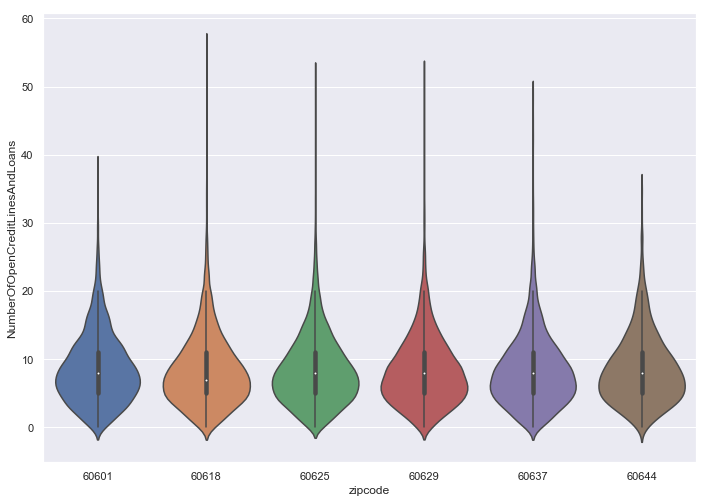

In [14]:
sns.violinplot(data=df, x="zipcode", y='NumberOfOpenCreditLinesAndLoans', figsize=(10,10))

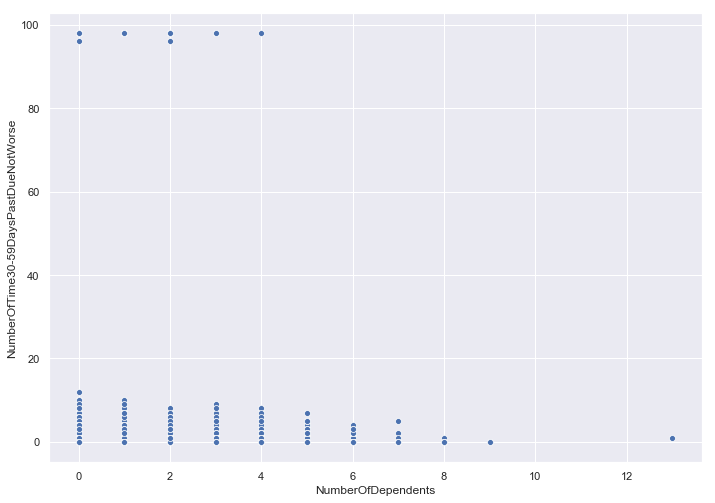

In [15]:
sns.scatterplot(x=df['NumberOfDependents'], y=df['NumberOfTime30-59DaysPastDueNotWorse'], data=df)

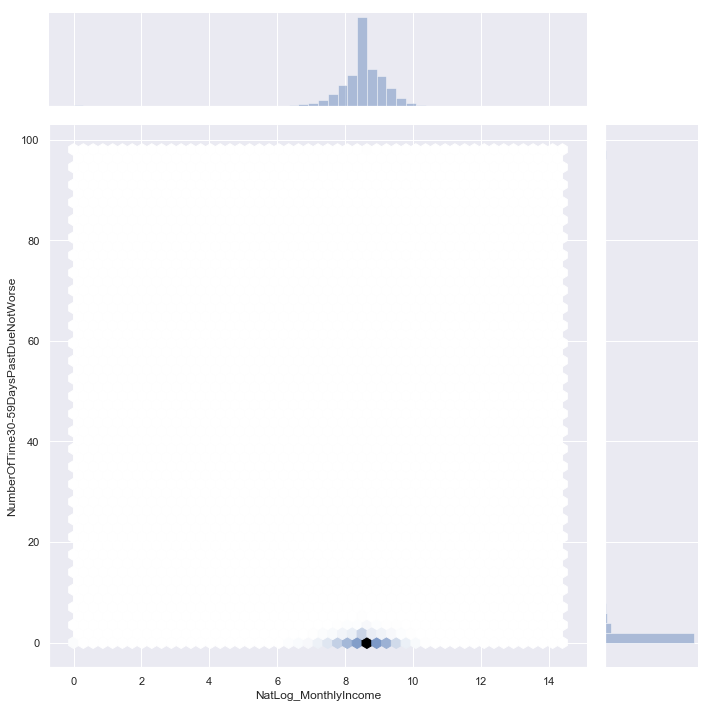

In [16]:
sns.jointplot(x=df['NatLog_MonthlyIncome'], y=df['NumberOfTime30-59DaysPastDueNotWorse'], kind='hex',height=10)

### Generate Features
I used the discretize function in pipeline.py to transform the continuous variable MonthlyIncome into a discrete one. To transform the categorical variable zipcode into a dummy variable, I used tree.format_df(), which takes in a dataframe, the columns you want to include in the tree, and passes feature columns to the pipeline.make_binary(), which makes dummy variables out of each feature. 


In [33]:
pipeline.discretize(df, 'MonthlyIncome', 10000)

In [39]:
tree_df = tree.format_df(df, tree.KEEP_COLS)

### Build Classifier
I built a decision tree classifier in order to predict who will experience financial distress over the next two years, which can be found in tree.py. To build the decision tree, you pass the data file to tree.build_tree(), which then fills null values, discretizes a given column, makes dummy variables out of the set feature columns, splits the data into training and testing sets, and returns a tree object.  

In [77]:
tst_tree = tree.buildtree('credit-data.csv')

### Evaluate Classifier 
After building the tree object, I can evaluate the classifier by first calling the predict method, which calls the predict_proba() from the tree classifier and sets the value equal to the y_hat attribute. 

In [78]:
tst_tree.predict()

In [79]:
tst_tree.y_hat

array([0.        , 0.33333333, 0.18535469, ..., 0.15      , 0.22222222,
       0.11704835])

In [80]:
threshold = .4

In [81]:
tst_tree.accuracy

0.8244758654314969